### Here we transform the NetCDF file into standard lists for further analyses 
#### We regrid the spatial resolution onto 1°×1°
#### Historical O${_3}$ simulations 1850-2014

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import iris
from eofs.iris import Eof

#### Prescribe the key parameters: 
##### i) target years for analysis (e.g. Y = 5 for five most recent years 2010-2014)
##### ii) ideal spatial resolutions (e.g. 360×180 grids)
###### These parameters are prescribed arbitrarily

In [2]:
Y = 5
lon = 360
lat = 180

#### Define the 1°×1° new spatial resolution for regridding (centred coordinates)

In [3]:
res_lon = 360/lon
res_lat = 180/lat
sample_points = [('longitude', np.linspace(0+res_lon/2, 360-res_lon/2, lon)),
                 ('latitude',  np.linspace(-90+res_lat/2, 90-res_lat/2, lat))]

In [4]:
sample_points

[('longitude',
  array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
           9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
          18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
          27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
          36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
          45.5,  46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,  53.5,
          54.5,  55.5,  56.5,  57.5,  58.5,  59.5,  60.5,  61.5,  62.5,
          63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,  70.5,  71.5,
          72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,  80.5,
          81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5,
          90.5,  91.5,  92.5,  93.5,  94.5,  95.5,  96.5,  97.5,  98.5,
          99.5, 100.5, 101.5, 102.5, 103.5, 104.5, 105.5, 106.5, 107.5,
         108.5, 109.5, 110.5, 111.5, 112.5, 113.5, 114.5, 115.5, 116.5,
         117.5, 118.5, 119.5, 120.5, 121.5, 122.5

#### Define the longitude-latitude-temporal sequence list

In [5]:
t = Y*12 ## Y years correspond to 12Y months 

lon_range = np.linspace(0+res_lon/2, 360-res_lon/2, lon)
lat_range = np.linspace(-90+res_lat/2, 90-res_lat/2, lat) 
t_range   = np.linspace(1, t, t) 
lat_mesh, t_mesh, lon_mesh = np.meshgrid(lat_range, t_range, lon_range) 

t_grid   = t_mesh.reshape(t*lon*lat, 1)
lon_grid = lon_mesh.reshape(t*lon*lat, 1)
lat_grid = lat_mesh.reshape(t*lon*lat, 1)

dataset = pd.DataFrame(lon_grid, columns = {'longitude'})
dataset['latitude'] = lat_grid
dataset['t'] = t_grid
dataset['loc'] = dataset['longitude']*1000+dataset['latitude']
dataset

longitude  latitude     t       loc
0              0.5     -89.5   1.0     410.5
1              1.5     -89.5   1.0    1410.5
2              2.5     -89.5   1.0    2410.5
3              3.5     -89.5   1.0    3410.5
4              4.5     -89.5   1.0    4410.5
...            ...       ...   ...       ...
3887995      355.5      89.5  60.0  355589.5
3887996      356.5      89.5  60.0  356589.5
3887997      357.5      89.5  60.0  357589.5
3887998      358.5      89.5  60.0  358589.5
3887999      359.5      89.5  60.0  359589.5

[3888000 rows x 4 columns]

#### 1.1. Import surface/ambient O${_3}$

In [6]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/o3_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'o3')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3 = values.reshape(t*lon*lat,1)
dataset['o3'] = o3

#### 1.2. Import surface/ambient O${_3}$ production rate 

In [7]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/o3prod_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'o3prod')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3prod = values.reshape(t*lon*lat,1)
dataset['o3prod'] = o3prod

#### 1.3. Import surface/ambient O${_3}$ loss rate

In [8]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/o3loss_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'o3loss')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3loss = values.reshape(t*lon*lat,1)
dataset['o3loss'] = o3loss

#### 2.1. Import total NO${_X}$ emission 

In [9]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/eminox_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'eminox')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
nox = values.reshape(t*lon*lat,1)
dataset['eminox'] = nox

#### 2.2. Import total VOC emission

In [10]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/emivoc_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'emivoc')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
voc = values.reshape(t*lon*lat,1)
dataset['emivoc'] = voc

#### 3.1. Import near-surface air temperature

In [11]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'tas')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
tas = values.reshape(t*lon*lat,1)
dataset['tas'] = tas

#### 3.2. Import ambient air humidity

In [12]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/hus_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'hus')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:,:]
data = data.collapsed('air_pressure', iris.analysis.MAX)
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
hus = values.reshape(t*lon*lat,1)
dataset['hus'] = hus

#### 3.3. Import aerosol optical depth at 550 nm

In [13]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/abs550aer_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'abs550aer')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
aod = values.reshape(t*lon*lat,1)
dataset['aod'] = aod

#### 3.4. Import planetary boundary layer height

In [14]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/bldep_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'bldep')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
pbl = values.reshape(t*lon*lat,1)
dataset['bldep'] = pbl

#### 3.5. Import eastward wind speed

In [15]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/ua_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'ua')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
ua = values.reshape(t*lon*lat,1)
dataset['ua'] = ua

#### 3.6. Import northward wind speed

In [16]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/va_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'va')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
va = values.reshape(t*lon*lat,1)
dataset['va'] = va

#### 4.1. Import NO${_2}$ photolysis rate

In [17]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/jno2_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'jno2')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
jno2 = values.reshape(t*lon*lat,1)
dataset['jno2'] = jno2

#### 4.2. Import O${_3}$→O(${^1}$D) photolysis rate

In [18]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/photo1d_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'photo1d')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
jo3 = values.reshape(t*lon*lat,1)
dataset['photo1d'] = jo3

#### 4.3. Import CH${_4}$ reaction loss rate

In [19]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/lossch4_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'lossch4')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
lossch4 = values.reshape(t*lon*lat,1)
dataset['lossch4'] = lossch4

#### 4.4. Import CO reaction loss rate

In [20]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/lossco_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'lossco')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
lossco = values.reshape(t*lon*lat,1)
dataset['lossco'] = lossco

#### 5.1. Import NO${_2}$ concentration

In [21]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/no2_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'no2')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
no2 = values.reshape(t*lon*lat,1)
dataset['no2'] = no2

#### 5.2. Import NO concentration

In [22]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/no_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'no')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
no = values.reshape(t*lon*lat,1)
dataset['no'] = no

#### 5.3. Import OH radical concentration

In [23]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/oh_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'oh')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
oh = values.reshape(t*lon*lat,1)
dataset['oh'] = oh

#### 5.4. Import H${_2}$O concentration

In [24]:
data = iris.load_cube('/Volumes/Database/CMIP6/NCAR/CESM2-WACCM-FV2/historical/h2o_AERmon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_200001-201412.nc', 'h2o')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,69,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
h2o = values.reshape(t*lon*lat,1)
dataset['h2o'] = h2o

#### 5.5. Import PAN reservoir concentration

In [25]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/pan_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'pan')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
pan = values.reshape(t*lon*lat,1)
dataset['pan'] = pan

#### 5.6. Import HNO${_3}$ reservoir concentration

In [26]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/hno3_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'hno3')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
hno3 = values.reshape(t*lon*lat,1)
dataset['hno3'] = hno3

#### We should convert 0-360° into 180°W-180°E scheme

In [27]:
dataset_pt1 = dataset[dataset['longitude'] < 180]
dataset_pt2 = dataset[dataset['longitude'] >= 180]
dataset_pt2['longitude'] = dataset_pt2['longitude']-360
dataset_adj = dataset_pt1.append(dataset_pt2)
dataset_adj

longitude  latitude     t       loc            o3        o3prod  \
0              0.5     -89.5   1.0     410.5  1.620264e-08  8.851048e-14   
1              1.5     -89.5   1.0    1410.5  1.620365e-08  8.849564e-14   
2              2.5     -89.5   1.0    2410.5  1.620512e-08  8.849765e-14   
3              3.5     -89.5   1.0    3410.5  1.620145e-08  8.845342e-14   
4              4.5     -89.5   1.0    4410.5  1.619546e-08  8.838817e-14   
...            ...       ...   ...       ...           ...           ...   
3887995       -4.5      89.5  60.0  355589.5  1.625719e-08  2.592225e-16   
3887996       -3.5      89.5  60.0  356589.5  1.626154e-08  2.874705e-16   
3887997       -2.5      89.5  60.0  357589.5  1.626564e-08  3.190250e-16   
3887998       -1.5      89.5  60.0  358589.5  1.626919e-08  3.578540e-16   
3887999       -0.5      89.5  60.0  359589.5  1.626867e-08  4.182003e-16   

               o3loss        eminox        emivoc         tas  ...      jno2  \
0        9.486186e-14  0.000000e+00  0.000000e+00  249.315536  ...  0.009917   
1        9.484101e-14  0.000000e+00  0.000000e+00  249.317978  ...  0.009915   
2        9.483044e-14  0.000000e+00  0.000000e+00  249.318008  ...  0.009913   
3        9.475983e-14  0.000000e+00  0.000000e+00  249.317261  ...  0.009911   
4        9.466191e-14  0.000000e+00  0.000000e+00  249.316177  ...  0.009908   
...               ...           ...           ...         ...  ...       ...   
3887995  1.724144e-16  4.536516e-15  8.978740e-17  242.586975  ...  0.000000   
3887996  1.777076e-16  2.883448e-14  5.686536e-16  242.592102  ...  0.000000   
3887997  1.845469e-16  8.455210e-14  1.666741e-15  242.594986  ...  0.000000   
3887998  1.947880e-16  2.093930e-13  4.127115e-15  242.592941  ...  0.000000   
3887999  2.052239e-16  4.195929e-13  8.269752e-15  242.590134  ...  0.000000   

          photo1d       lossch4        lossco           no2            no  \
0        0.000009  5.323004e-14  1.290871e-13  9.071835e-13  2.542928e-12   
1        0.000009  5.321699e-14  1.290471e-13  9.072891e-13  2.543200e-12   
2        0.000009  5.321622e-14  1.290376e-13  9.074047e-13  2.543474e-12   
3        0.000009  5.317563e-14  1.289299e-13  9.073652e-13  2.543127e-12   
4        0.000009  5.311696e-14  1.287774e-13  9.072549e-13  2.542499e-12   
...           ...           ...           ...           ...           ...   
3887995  0.000000  2.170215e-17  1.479111e-16  3.082256e-11  1.624503e-12   
3887996  0.000000  2.282093e-17  1.558934e-16  3.120339e-11  2.081422e-12   
3887997  0.000000  2.412771e-17  1.649820e-16  3.135838e-11  2.706787e-12   
3887998  0.000000  2.584810e-17  1.765042e-16  3.101652e-11  3.702734e-12   
3887999  0.000000  2.827549e-17  1.928419e-16  3.123548e-11  5.408039e-12   

                   oh       h2o           pan          hno3  
0        2.266205e-14  0.000566  1.964474e-11  5.425556e-12  
1        2.265963e-14  0.000565  1.964651e-11  5.429875e-12  
2        2.265864e-14  0.000564  1.964809e-11  5.438436e-12  
3        2.264234e-14  0.000564  1.964544e-11  5.434345e-12  
4        2.261907e-14  0.000563  1.964086e-11  5.424503e-12  
...               ...       ...           ...           ...  
3887995  4.657551e-18  0.000485  6.126436e-11  1.864855e-10  
3887996  4.719662e-18  0.000485  6.127356e-11  1.865039e-10  
3887997  4.769793e-18  0.000485  6.128126e-11  1.865188e-10  
3887998  4.793568e-18  0.000484  6.128573e-11  1.865262e-10  
3887999  4.926912e-18  0.000484  6.128462e-11  1.865146e-10  

[3888000 rows x 25 columns]

#### Calculate the kinetic rates

In [28]:
dataset_adj['k_no_ho2']   = 3.30*10**(-12)*np.exp(-270/dataset_adj['tas'])
dataset_adj['k_no_ch3o2'] = 2.30*10**(-12)*np.exp(-360/dataset_adj['tas'])
dataset_adj['k_o1d_h2o']  = 1.63*10**(-10)*np.exp(-60/dataset_adj['tas'])
dataset_adj['k_o3_ho2']   = 2.03*10**(-16)*(dataset_adj['tas']/300)**4.57*np.exp(-693/dataset_adj['tas'])
dataset_adj['k_o3_oh']    = 1.70*10**(-12)*np.exp(-940/dataset_adj['tas'])

#### Calculate the procedural auxilliary variables 
##### where K1's are aggressive approach to use as many associated variables as possible 
##### and K2's are conservative approach to only use variables that we trust the credibility 

In [29]:
dataset_adj['K1_NO_HO2']   = dataset_adj['k_no_ho2'] * dataset_adj['no'] * dataset_adj['lossco']
dataset_adj['K1_NO_CH3O2'] = dataset_adj['k_no_ch3o2'] * dataset_adj['no'] * dataset_adj['lossch4']
dataset_adj['K1_O1D_H2O']  = dataset_adj['k_o1d_h2o'] * dataset_adj['photo1d'] * dataset_adj['o3'] * dataset_adj['hus']
dataset_adj['K1_O3_OH']    = dataset_adj['k_o3_oh'] * dataset_adj['o3'] * dataset_adj['oh'] 
dataset_adj['K1_O3_HO2']   = dataset_adj['k_o3_ho2'] * dataset_adj['o3'] * dataset_adj['lossco']

In [30]:
dataset_adj['K2_NO_HO2']   = dataset_adj['k_no_ho2'] * dataset_adj['no']
dataset_adj['K2_NO_CH3O2'] = dataset_adj['k_no_ch3o2'] * dataset_adj['no']
dataset_adj['K2_O1D_H2O']  = dataset_adj['k_o1d_h2o'] * dataset_adj['photo1d'] * dataset_adj['o3']
dataset_adj['K2_O3_OH']    = dataset_adj['k_o3_oh'] * dataset_adj['o3'] * dataset_adj['oh'] 
dataset_adj['K2_O3_HO2']   = dataset_adj['k_o3_ho2'] * dataset_adj['o3']

In [31]:
dataset_adj.to_csv('/Volumes/Database/Research/C7 Multivariate analysis/UKESM1-0-LL_diag_2014(1119).csv', index = False)
#dataset_adj.to_stata('/Volumes/Database/Research/C7 Multivariate analysis/UKESM1-0-LL_diag_2014(1119).dta')

### Map the variables to ensure correct gridding

(-90.0, 90.0)

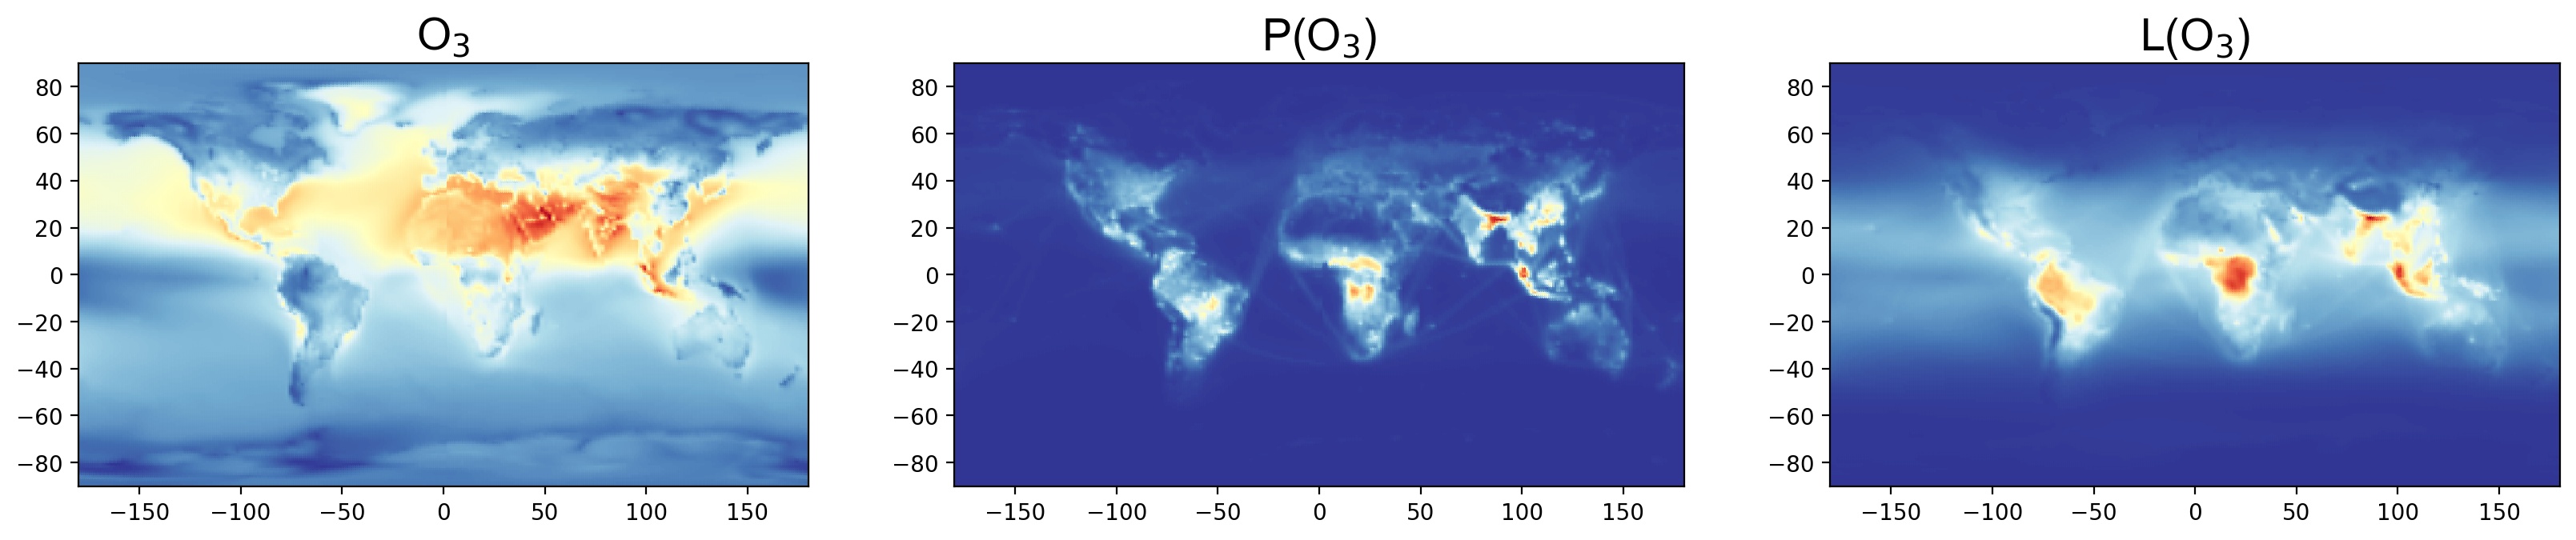

In [32]:
dataset_map = dataset_adj.groupby('loc').mean()
temp = dataset_map

plt.figure(num=None, figsize=(20, 3.5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,3,1)
plt.title('O${_3}$', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,2)
plt.title('P(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3prod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,3)
plt.title('L(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3loss'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

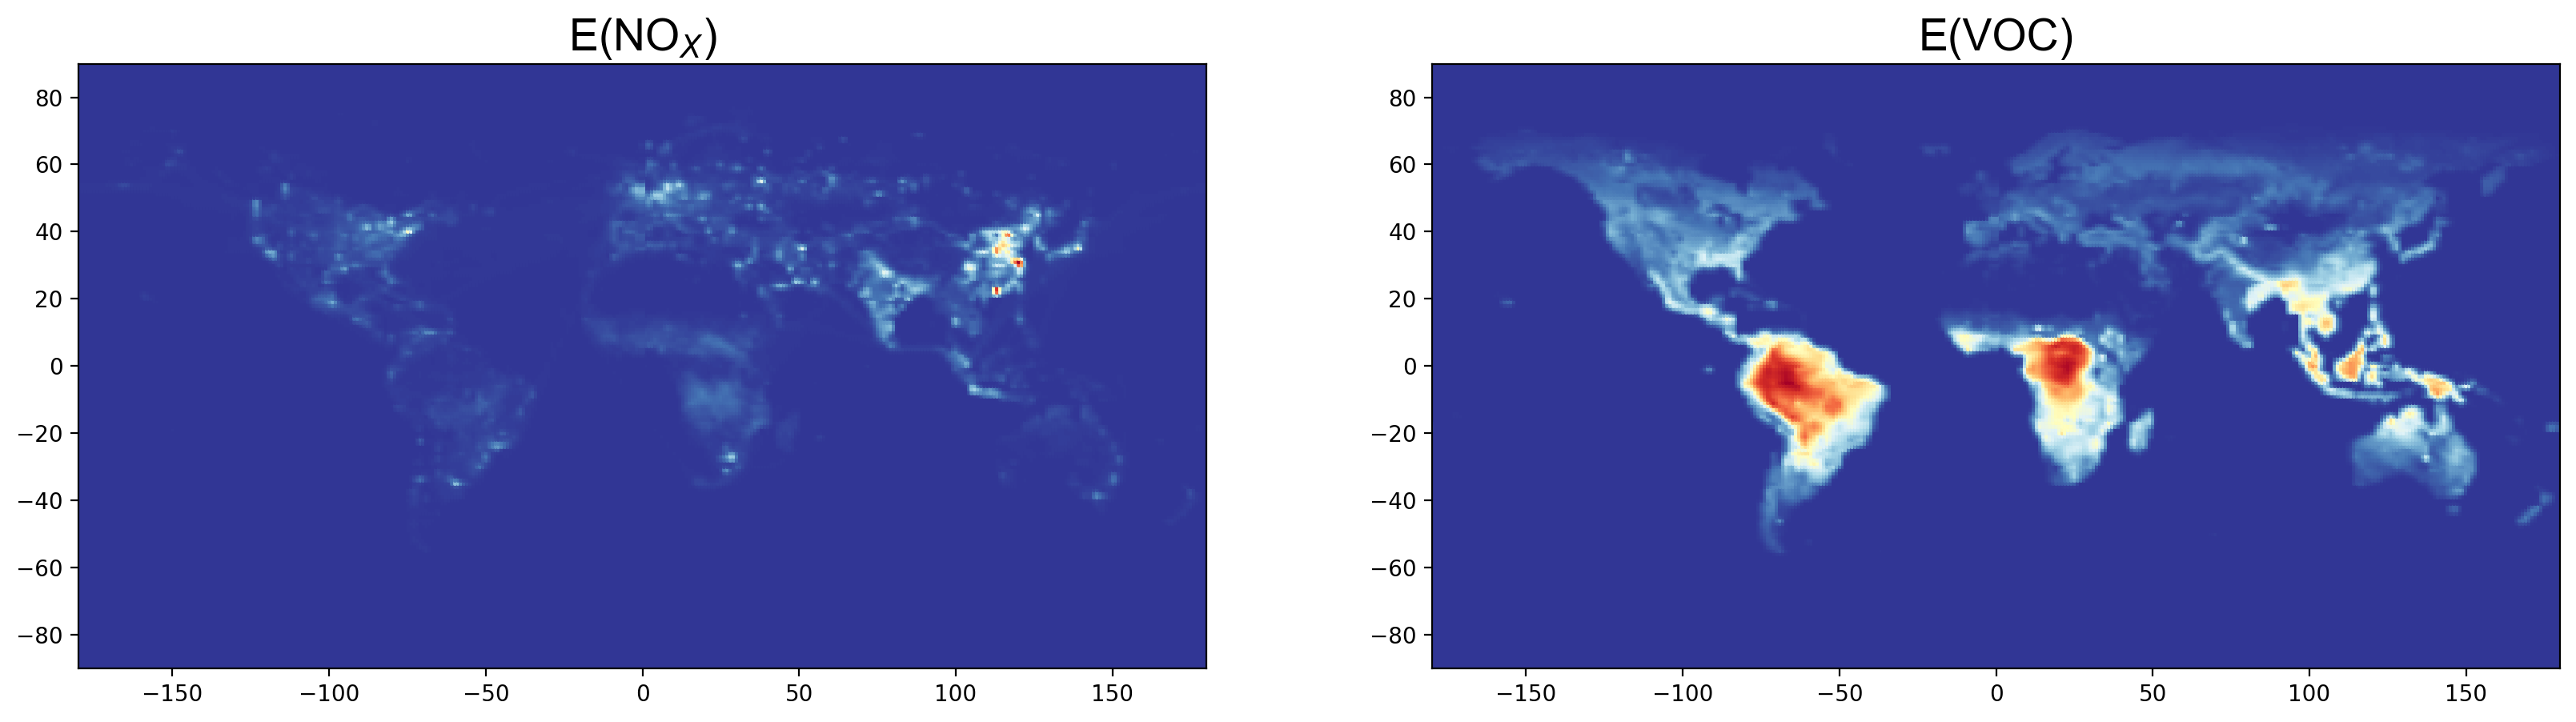

In [33]:
plt.figure(num=None, figsize=(20, 5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,2,1)
plt.title('E(NO${_X}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['eminox'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,2,2)
plt.title('E(VOC)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['emivoc'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

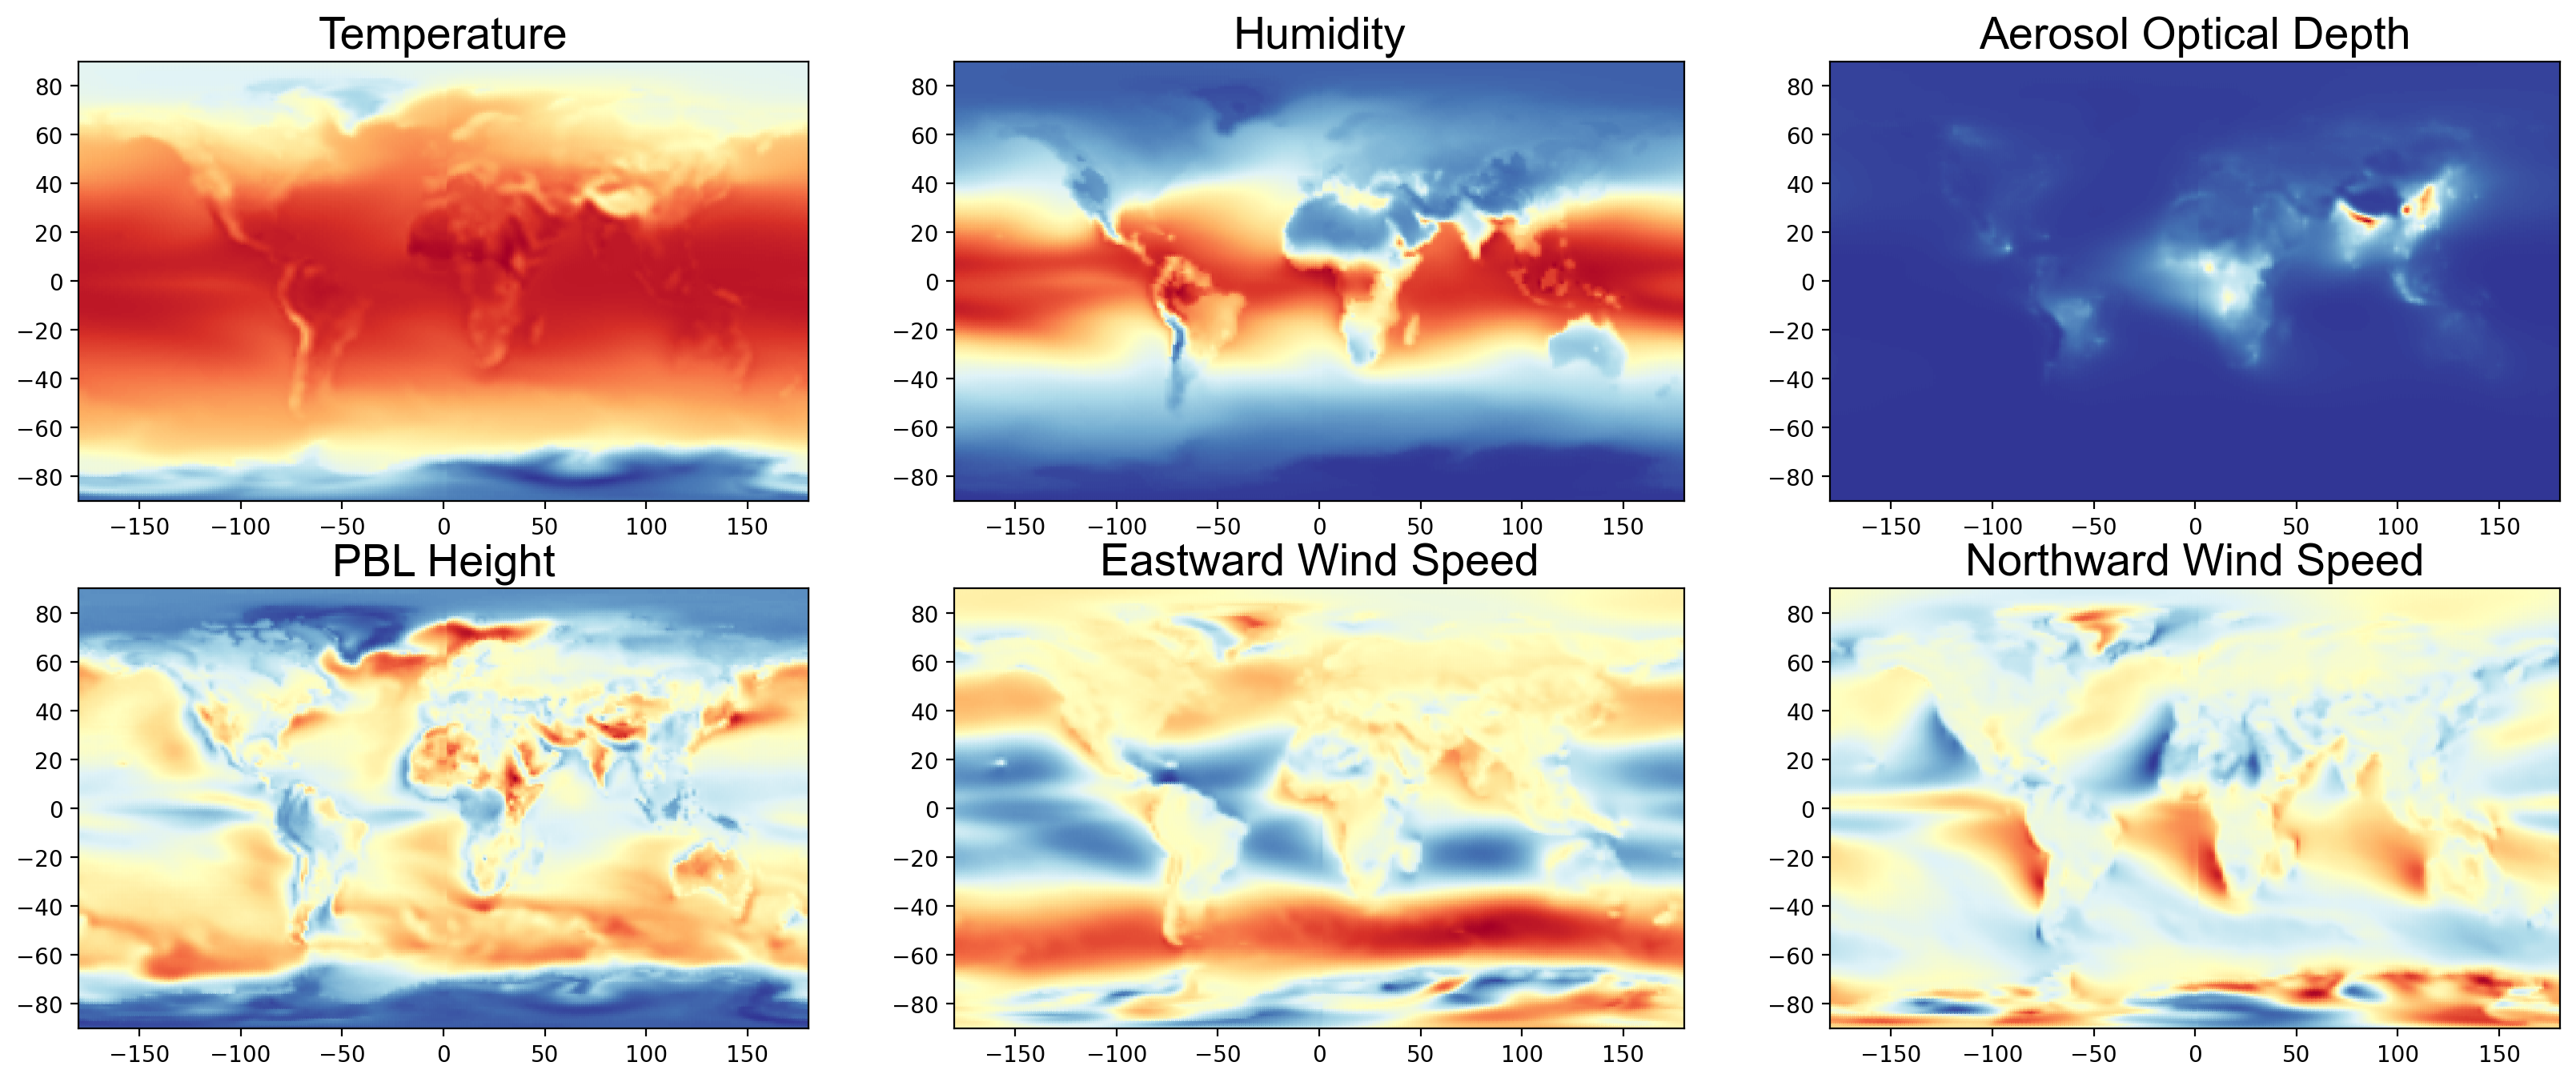

In [34]:
plt.figure(num=None, figsize=(20, 8), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(2,3,1)
plt.title('Temperature', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['tas'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,2)
plt.title('Humidity', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['hus'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,3)
plt.title('Aerosol Optical Depth', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['aod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,4)
plt.title('PBL Height', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['bldep'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,5)
plt.title('Eastward Wind Speed', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['ua'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,6)
plt.title('Northward Wind Speed', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['va'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

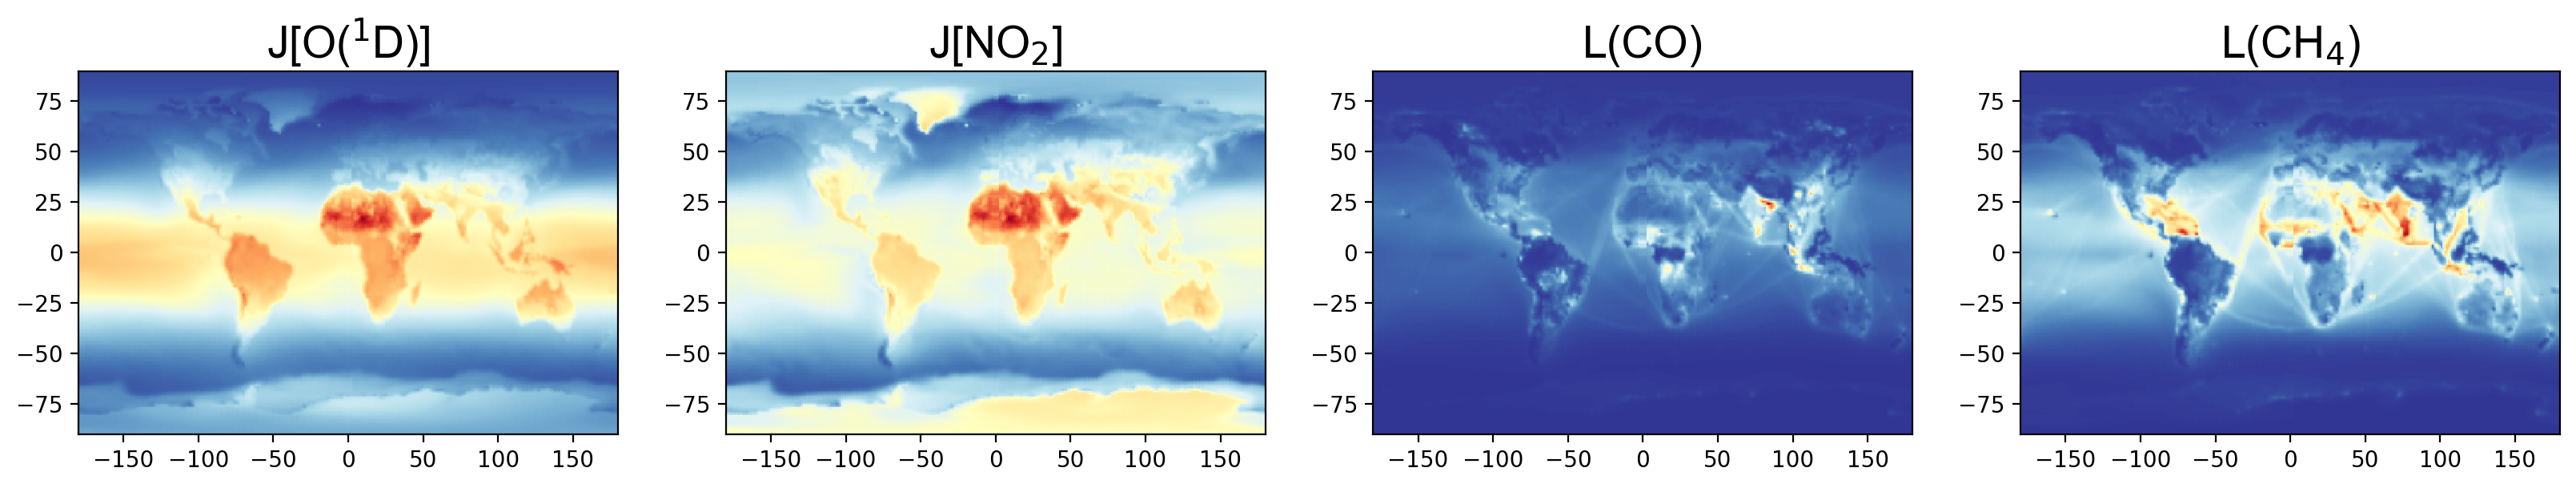

In [35]:
plt.figure(num=None, figsize=(20, 3), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(1,4,1)
plt.title('J[O(${^1}$D)]', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['photo1d'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,2)
plt.title('J[NO${_2}$]', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['jno2'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,3)
plt.title('L(CO)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['lossco'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,4)
plt.title('L(CH${_4}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['lossch4'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

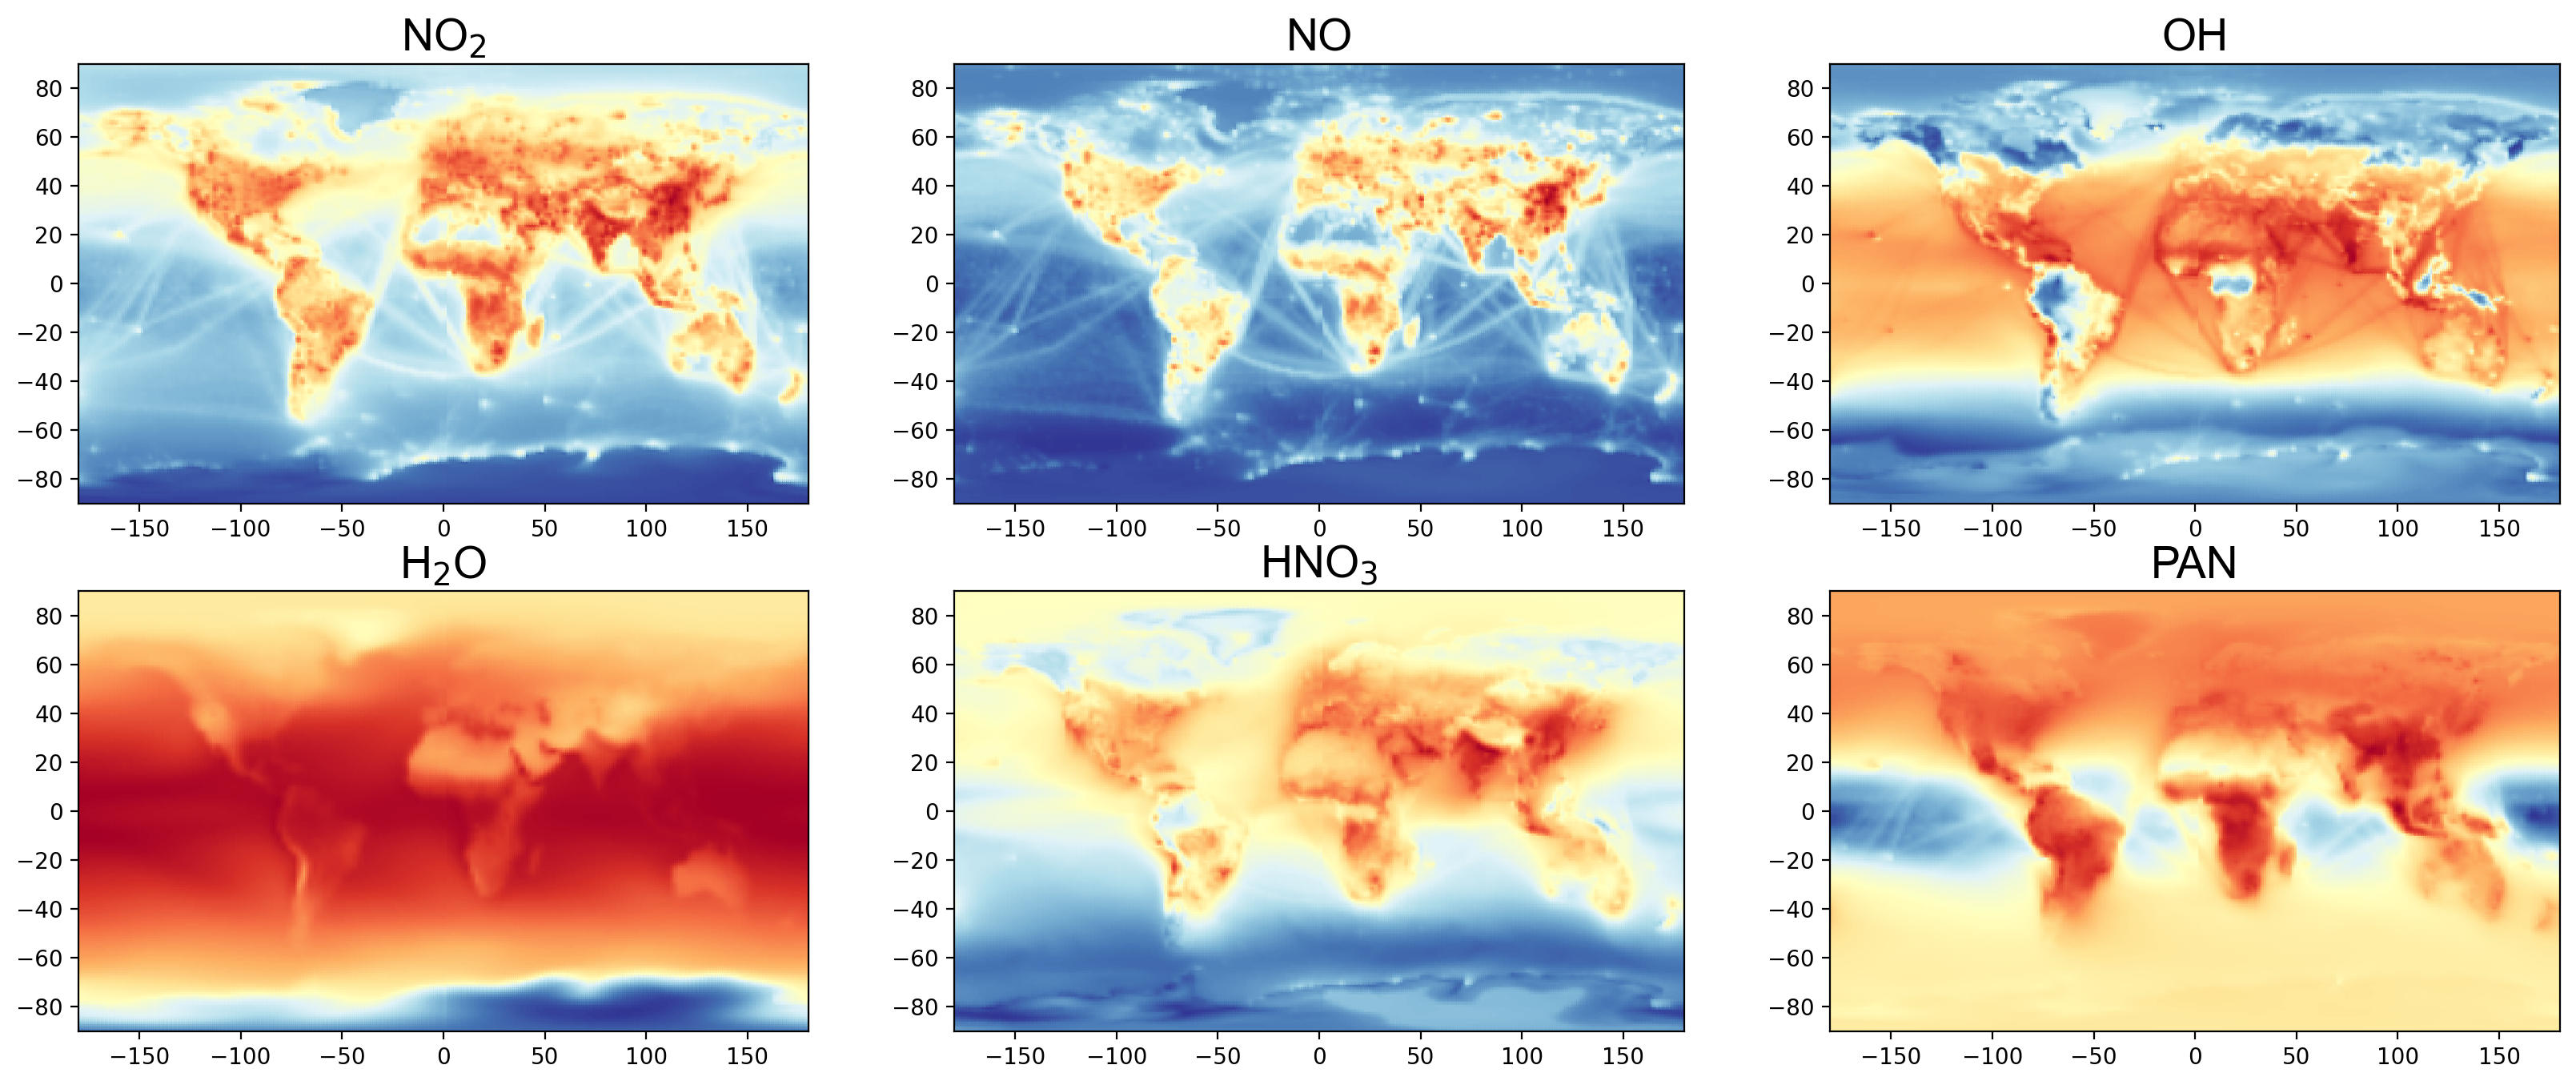

In [36]:
plt.figure(num=None, figsize=(20, 8), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(2,3,1)
plt.title('NO${_2}$', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['no2'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,2)
plt.title('NO', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['no'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,3)
plt.title('OH', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['oh'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,4)
plt.title('H${_2}$O', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['h2o'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,5)
plt.title('HNO${_3}$', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['hno3'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,6)
plt.title('PAN', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['pan'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

#### We should now check whether each variable has been correctly extracted without any erroneous values (e.g. negative concentrations)

In [37]:
dataset_adj['eminox'].describe()

count    3.888000e+06
mean     5.714657e-12
std      2.101811e-11
min     -1.877425e-14
25%      2.667994e-14
50%      3.141004e-13
75%      2.614262e-12
max      1.063301e-09
Name: eminox, dtype: float64

In [38]:
dataset_adj['emivoc'].describe()

count    3.888000e+06
mean     3.599136e-11
std      1.195414e-10
min     -3.712380e-16
25%      4.172852e-14
50%      3.912179e-13
75%      1.435552e-12
max      3.430343e-09
Name: emivoc, dtype: float64

In [39]:
dataset_adj['o3'].describe()

count    3.888000e+06
mean     2.661093e-08
std      1.058581e-08
min      7.582018e-10
25%      1.866583e-08
50%      2.520114e-08
75%      3.231011e-08
max      1.305962e-07
Name: o3, dtype: float64

In [40]:
dataset_adj['o3prod'].describe()

count    3.888000e+06
mean     2.387981e-12
std      5.749740e-12
min     -8.992501e-17
25%      6.933281e-14
50%      4.517924e-13
75%      1.885449e-12
max      4.015217e-10
Name: o3prod, dtype: float64

In [41]:
dataset_adj['o3loss'].describe()

count    3.888000e+06
mean     1.062527e-12
std      1.362793e-12
min      6.950640e-19
25%      6.073543e-14
50%      4.558894e-13
75%      1.700776e-12
max      3.234472e-11
Name: o3loss, dtype: float64

In [42]:
dataset_adj['tas'].describe()

count    3.888000e+06
mean     2.791070e+02
std      2.214743e+01
min      1.949706e+02
25%      2.678405e+02
50%      2.834267e+02
75%      2.965451e+02
max      3.151748e+02
Name: tas, dtype: float64

In [43]:
dataset_adj['hus'].describe()

count    3.888000e+06
mean     6.803391e-03
std      5.677687e-03
min      3.615331e-05
25%      2.008561e-03
50%      5.103346e-03
75%      1.130147e-02
max      2.328975e-02
Name: hus, dtype: float64

In [44]:
dataset_adj['aod'].describe()

count    3.888000e+06
mean     5.015133e-03
std      1.113783e-02
min      4.018864e-05
25%      4.102471e-04
50%      1.824365e-03
75%      4.749179e-03
max      3.633934e-01
Name: aod, dtype: float64

In [45]:
dataset_adj['bldep'].describe()

count    3.888000e+06
mean     8.215404e+02
std      4.153668e+02
min      2.483233e+01
25%      5.554000e+02
50%      8.460800e+02
75%      1.097363e+03
max      3.713767e+03
Name: bldep, dtype: float64

In [46]:
dataset_adj['ua'].describe()

count    3.888000e+06
mean    -9.927483e-02
std      3.818311e+00
min     -1.332051e+01
25%     -2.362647e+00
50%     -7.814046e-02
75%      1.906484e+00
max      1.249657e+01
Name: ua, dtype: float64

In [47]:
dataset_adj['va'].describe()

count    3.888000e+06
mean     1.716100e-01
std      2.393407e+00
min     -1.220520e+01
25%     -1.194509e+00
50%      3.040853e-02
75%      1.419752e+00
max      1.270521e+01
Name: va, dtype: float64

In [48]:
dataset_adj['jno2'].describe()

count    3.888000e+06
mean     2.672604e-03
std      1.912119e-03
min      0.000000e+00
25%      1.194585e-03
50%      2.842092e-03
75%      3.511445e-03
max      1.142627e-02
Name: jno2, dtype: float64

In [49]:
dataset_adj['photo1d'].describe()

count    3.888000e+06
mean     5.412376e-06
std      4.639638e-06
min      0.000000e+00
25%      8.560717e-07
50%      4.708891e-06
75%      9.381522e-06
max      3.186541e-05
Name: photo1d, dtype: float64

In [50]:
dataset_adj['no2'].describe()

count    3.888000e+06
mean     5.348351e-10
std      1.970529e-09
min      9.939747e-14
25%      8.467694e-12
50%      3.259968e-11
75%      1.825014e-10
max      1.260170e-07
Name: no2, dtype: float64

In [51]:
dataset_adj['no'].describe()

count    3.888000e+06
mean     3.003732e-10
std      2.993750e-09
min     -2.883664e-13
25%      1.620474e-12
50%      6.006740e-12
75%      3.668804e-11
max      3.018214e-07
Name: no, dtype: float64

In [52]:
dataset_adj['oh'].describe()

count    3.888000e+06
mean     4.337371e-14
std      4.617734e-14
min      1.595247e-20
25%      4.885240e-15
50%      2.669105e-14
75%      7.300285e-14
max      3.958347e-13
Name: oh, dtype: float64

In [53]:
dataset_adj['h2o'].describe()

count    3.888000e+06
mean     7.499787e-03
std      6.060463e-03
min      9.185272e-06
25%      2.475115e-03
50%      5.774958e-03
75%      1.252844e-02
max      2.275142e-02
Name: h2o, dtype: float64

In [54]:
dataset_adj['hno3'].describe()

count    3.888000e+06
mean     2.707342e-10
std      7.203870e-10
min      2.472657e-13
25%      1.302204e-11
50%      6.645597e-11
75%      2.152056e-10
max      3.254788e-08
Name: hno3, dtype: float64

In [55]:
dataset_adj['pan'].describe()

count    3.888000e+06
mean     7.258397e-11
std      1.148272e-10
min      7.167879e-14
25%      1.463945e-11
50%      2.751656e-11
75%      9.457972e-11
max      1.464616e-08
Name: pan, dtype: float64

In [56]:
dataset_adj['lossco'].describe()

count    3.888000e+06
mean     8.190160e-13
std      1.197635e-12
min      4.157394e-19
25%      8.011918e-14
50%      4.375021e-13
75%      1.180525e-12
max      1.382263e-10
Name: lossco, dtype: float64

In [57]:
dataset_adj['lossch4'].describe()

count    3.888000e+06
mean     4.424544e-13
std      5.230504e-13
min      6.516282e-20
25%      2.925132e-14
50%      2.055023e-13
75%      7.773560e-13
max      4.671182e-12
Name: lossch4, dtype: float64

#### Ok, now we find the reason why there are erroneous negative values: it is because the interpolation resolution here 1°×1° is too fine to balance the small values and spatial gaps. We then decide to use 2°×2° as our analysis standard. 